# Portfolio optimization

### Import Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt 
import yfinance as yf 
import matplotlib.pyplot as plt 
from scipy.stats import norm
import warnings
warnings.simplefilter('ignore')

### Define data timerange and tickers to get data

In [2]:
years = 7
enddate = dt.datetime.now()
startdate = enddate - dt.timedelta(days = 365*years)

In [3]:
enddate

datetime.datetime(2024, 7, 22, 11, 45, 11, 714071)

In [4]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [5]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = startdate, end = enddate)
    adj_close_df[ticker] = data['Adj Close'] 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### calculate log return on adjusted return on stocks

In [6]:
adj_close_df = adj_close_df.sort_values(by = "Date")

In [7]:
log_return = np.log(adj_close_df/adj_close_df.shift(1))
log_return = log_return.dropna()


In [8]:
log_return

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2017-07-25,0.002428,-0.003785,-0.003274,-0.002560,0.003303
2017-07-26,0.000041,0.002444,0.008040,0.003250,-0.000707
2017-07-27,-0.000930,-0.001221,-0.000751,-0.006301,-0.001730
2017-07-28,-0.001174,0.001831,0.007485,-0.000834,-0.001654
2017-07-31,-0.000567,-0.000122,0.000497,-0.004249,-0.000552
...,...,...,...,...,...
2024-07-15,0.002746,-0.003157,0.003222,0.002684,0.004272
2024-07-16,0.005913,0.003841,0.019730,0.000383,0.008203
2024-07-17,-0.014120,0.000958,-0.004654,-0.029794,-0.014217


### Calculating covariane matrix

In [9]:
co_matrix = log_return.cov() * 252
print(co_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.037103  0.001878  0.002550  0.042659  0.037788
BND  0.001878  0.003666  0.003096  0.002321  0.002014
GLD  0.002550  0.003096  0.019657  0.003443  0.002725
QQQ  0.042659  0.002321  0.003443  0.056606  0.043387
VTI  0.037788  0.002014  0.002725  0.043387  0.038806


### Setup inital weights

In [10]:
#portfolio_value = 100000
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [11]:
# creating finction
def port_stddev(weights, co_matrix):
    variance = weights.T @ co_matrix @ weights
    return np.sqrt(variance)


def expected_return(weights,log_return):
    return np.sum(log_return.mean()*weights)*252
    

In [12]:
def sharpe_ratio(weights, log_returns,co_matrix,risk_free_rate):
    return (expected_return(weights,log_return) - risk_free_rate)/port_stddev(weights, co_matrix)

### Defining risk-free rates and calculation of expected returns,standard deviation and Sharpe ration based on input
### weightes generated from 3000 simulations, creating the dataframe having all metrics

In [13]:
risk_free_rate = 0.02

In [14]:
numofport  = 3000
numberofsymbol = len(tickers)
all_weight = np.zeros((numofport,numberofsymbol))
ret_arr = np.zeros(numofport)
vol_arr = np.zeros(numofport)
sharpe_arr = np.zeros(numofport)
for ind in range(numofport):
    weights_r = np.array(np.random.random(numberofsymbol))
    weights_r = weights_r/np.sum(weights_r)
    all_weight[ind,:] = weights_r
    ret_arr[ind] = expected_return(weights_r,log_return)
    vol_arr[ind] = port_stddev(weights_r, co_matrix)
    sharpe_arr[ind] = sharpe_ratio(weights_r, log_return,co_matrix,risk_free_rate)

simulation_data = [ret_arr, vol_arr,sharpe_arr, all_weight]
simulations_df = pd.DataFrame(simulation_data)
simulations_df = simulations_df. T
# Give the columns the Proper Names.
simulations_df.columns = ['Returns','Volatility','Sharpe Ratio','Portfolio Weights']

# Make sure the data types are correct, we don't want our floats to be strings.
                          


simulations_df = simulations_df.infer_objects()
# Print out the results.
print('')
print('='*80)
print ('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.107843    0.131187      0.669601   
1  0.111592    0.133682      0.685149   
2  0.108310    0.155821      0.566744   
3  0.104557    0.145626      0.580647   
4  0.101398    0.122084      0.666738   

                                   Portfolio Weights  
0  [0.11011738149072661, 0.23714104970709843, 0.2...  
1  [0.24517995516731175, 0.18749069270561838, 0.2...  
2  [0.013289988675982594, 0.21335657591656876, 0....  
3  [0.09989926920040969, 0.3160782827809969, 0.01...  
4  [0.13137084638948457, 0.2728213459769912, 0.21...  
--------------------------------------------------------------------------------


In [15]:
# Grab the Max Sharpe Ratio.
max_sharpe_ratio = simulations_df.loc[simulations_df[ 'Sharpe Ratio'].idxmax()]
# Return the Min Volatility from the Run.
min_volatility = simulations_df.loc[simulations_df[ 'Volatility']. idxmin()]
print ('')
print ('='*80)
print( 'MAX SHARPE RATIO: ')

print('-'*80)
print (max_sharpe_ratio)
print ('-'*80)
print('')
print('= '*80)

print('MIN VOLATILITY: ')
print(' -'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO: 
--------------------------------------------------------------------------------
Returns                                                        0.13263
Volatility                                                    0.146046
Sharpe Ratio                                                  0.771195
Portfolio Weights    [0.07141770135447963, 0.014199683227366058, 0....
Name: 2165, dtype: object
--------------------------------------------------------------------------------

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
MIN VOLATILITY: 
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Returns                                                       0.040489
Volatility                                                    0.070555
Sharpe Ratio              

### Getting the set of metrics based on maximum sharpe ratio and minimum-volatility

In [16]:
maxshar_w = max_sharpe_ratio["Portfolio Weights"]
min_volatility_w = min_volatility["Portfolio Weights"]

In [17]:
print(maxshar_w)
print(min_volatility_w)

[0.0714177  0.01419968 0.43653225 0.46975546 0.00809491]
[0.0493933  0.78364017 0.00564634 0.10094595 0.06037425]


### Okay with our functions now defined, let's run the optimization using the scipy optimization module. This module has a function called minimize which we can use to help our optimal value. however we need to do few things before we can run into it. First we need to define bound which tell minizime fintion that each of our position can only  be between 0% and 100% of allocation. Seend, we reed to define the constraint which will be fun(function) that ensures we equ(equal) a 100% allocated portfolio. In other words, we use all the "capital" we can. Third, we need to define our initial guess of the weights. The initial guess can be anything but in this case let's make it easy and start with an equally  distirbuted portofolio. In this case we have 4 symbols so each symbol will be 25% of the portfolio.Once we've define this steps we can run the optimization by passing through the arguments defined and defining the method as SISeP which is short for Sequential Least Squares Programming. Now, the different optimization methods are a whole different topic and is outside the scope of this tutorial. Once we run the minimize method we can grab the results.The first is the results of our minimization operation. Inside the results, you'll see the optimize sharpe ration defined by the fun   value. We can then take the optimized_weights defined by the optimized_sharpe.x values, and use them to return the different metrics we have for our portfolio

### if we want to optimize based on the sharpe ratio we need to define a function that returns only the sharpe ratio. 
### Since our optimization functions naturaily seek to minimize, we can minimize one of two quantities:
### The negative of the sharpe ratio, (or 1/1+Sharpe Ratio).
### Accordingly, if the sharpe ratio increases both of these quantities will

In [18]:
def neg_sharpe_ratio(weights, log_return, co_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_return, co_matrix, risk_free_rate)

In [19]:
constraints = {'type': 'eq','fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers) )]

In [20]:
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [21]:
from scipy.optimize import minimize

In [22]:
risk_free_rate

0.02

In [23]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights,
                             args=(log_return, co_matrix, risk_free_rate),
                             method= 'SLSQP', constraints=constraints, bounds=bounds)

In [24]:
print(optimized_results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.759734345716436
       x: [ 2.000e-01  0.000e+00  4.000e-01  4.000e-01  0.000e+00]
     nit: 4
     jac: [-5.206e-03  1.874e-02 -2.623e-01 -7.207e-02  5.152e-02]
    nfev: 24
    njev: 4


In [25]:
optimised_weights = optimized_results.x

In [26]:
print(optimised_weights)

[0.2 0.  0.4 0.4 0. ]


In [27]:
print ("Optimal Weights:")
for ticker, weight in zip(tickers, optimised_weights):
    print(f"{ticker}: {weight: .4f}")
print()
optimal_portfolio_return = expected_return (optimised_weights, log_return)
optimal_portfolio_volatility = port_stddev (optimised_weights, co_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimised_weights, log_return, co_matrix, risk_free_rate)


Optimal Weights:
SPY:  0.2000
BND:  0.0000
GLD:  0.4000
QQQ:  0.4000
VTI:  0.0000



In [28]:
optimal_portfolio_volatility

0.14839565163804086

In [29]:
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio: .4f}")

Expected Annual Return: 0.1327
Expected Volatility: 0.1484
Sharpe Ratio:  0.7597


In [30]:
# Expected Annual Return: 0.4392
# Expected Volatility: 0.1866
# Sharpe Ratio:  2.2464

In [31]:
import matplotlib.pyplot as plt
# Import the required library
import matplotlib.pyplot as plt
# Create a bar chart of tile optimal weights
# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimised_weights)
# # Add labels and a title
# plt. xlabel ('Assets')
# plt. ylabel ('Optimal Weights')
# plt. title('Optimal Portfolio Weights')
# # Display the chart
# plt.show()

In [32]:
def get_metrics(weights: list):
# convert the weights to a numpy array.
    weights = np. array(weights)
# Calculate the returns.
    return np.sum(log_return.mean()*weights)*252

In [33]:
get_metrics(optimised_weights)

0.13274127330439114

(-10.0, 10.0)

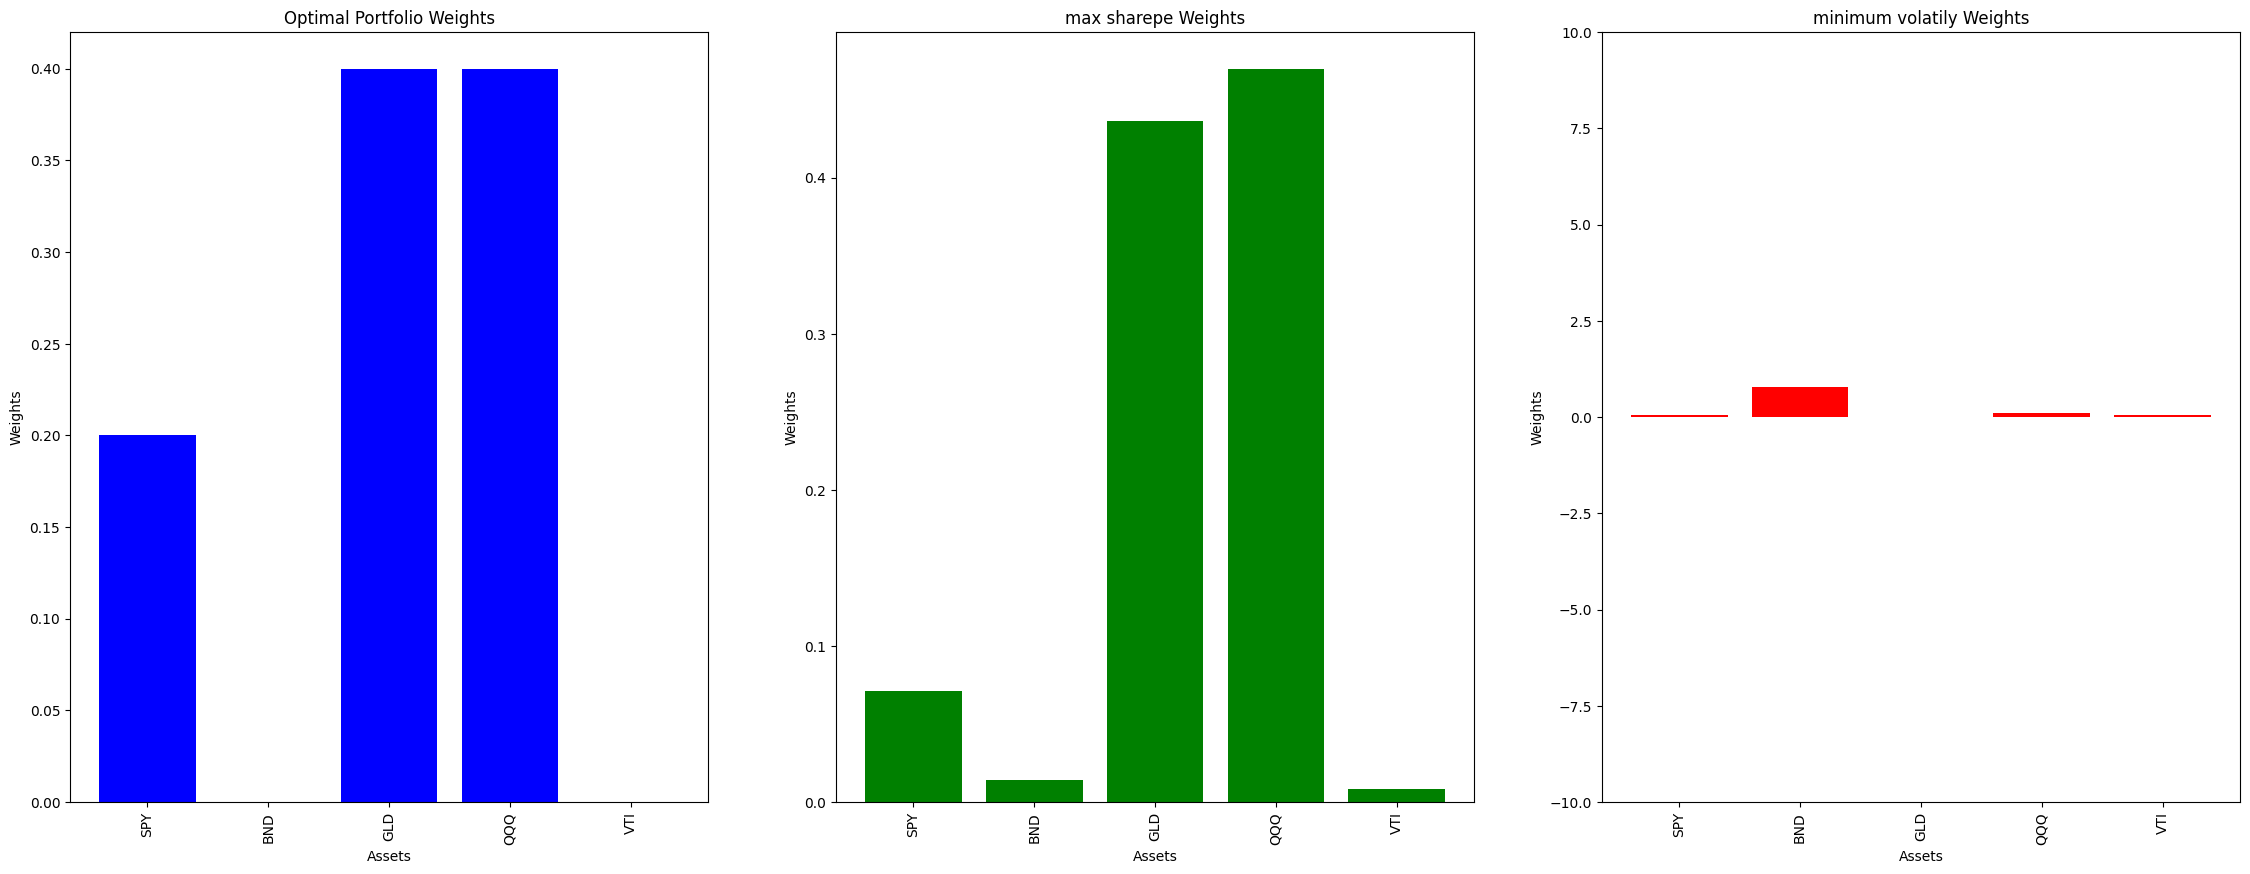

In [34]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (28,10))
ax1.bar(tickers,optimised_weights,color='blue')
ax1.set_title('Optimal Portfolio Weights')
ax1.set_xlabel('Assets')
ax1.set_ylabel('Weights')
ax1.set_xticklabels(tickers, rotation=90)

ax2.bar(tickers,maxshar_w,color='green')
ax2.set_title('max sharepe Weights')
ax2.set_xlabel('Assets')
ax2.set_ylabel('Weights')
ax2.set_xticklabels(tickers, rotation=90)

ax3.bar(tickers,min_volatility_w,color='red')
ax3.set_title('minimum volatily Weights')
ax3.set_xlabel('Assets')
ax3.set_ylabel('Weights')
ax3.set_xticklabels(tickers, rotation=90)
ax3.set_ylim(-10, 10) 


# plt.figure(figsize=(10, 6))
# plt.bar(tickers, maxshar_w)
# # Add labels and a title
# plt. xlabel ('Assets')
# plt. ylabel ('Optimal Weights')
# plt. title('Optimal Portfolio Weights')
# # Display the chart
# plt.show()

In [35]:
print(optimised_weights)

[0.2 0.  0.4 0.4 0. ]
